# import

In [1]:
import pandas as pd
import json
import requests
from pathlib import Path
import numpy as np
import sys
import requests
import json
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline


# directories


In [2]:
if sys.platform =='linux':
    path_d = Path('/mnt/d')
else:
    path_d = Path('D://')
data_dir = path_d/'data'/'dpe'/'upload'    

plot_dir = Path('.')/'plot'
plot_dir.mkdir(exist_ok=True,parents=True)

In [3]:
useless_cols = ['type_vitrage_verriere','nombre_entrees_avec_sas','nombre_entrees_sans_sas'] 

# variables essentielles TD001

In [4]:
useful_cols = ['date_reception_dpe','date_etablissement_dpe','date_visite_diagnostiqueur',
               'nom_methode_dpe', 'version_methode_dpe','tr001_modele_dpe_id',
               'organisme_certificateur','dpe_vierge','consommation_energie','estimation_ges','classe_consommation_energie','classe_estimation_ges','numero_dpe',
              'tr002_type_batiment_id','annee_construction']

dept_dict = dict()
for td001_dpe_file in data_dir.iterdir():
    dept = td001_dpe_file.name.split('-')[1].zfill(2)
    dpe_table = pd.read_csv(td001_dpe_file,sep=',',error_bad_lines=False,dtype=str,index_col=0)
    cols = [col for col in dpe_table if col in useful_cols]
    dpe_table = dpe_table.sort_values('date_reception_dpe').drop_duplicates('numero_dpe',keep='last')
    dept_dict[dept] = dpe_table[cols]
    

# analyse des métadonnées de dépot dans la base

## dates

quel est le flux et les dates de validités de la base DPE

In [5]:
date_dict = dict()
for date in ['date_reception_dpe','date_etablissement_dpe','date_visite_diagnostiqueur']:

    s_date=pd.Series()

    for dpe_table in dept_dict.values():
        s=pd.Series(index=dpe_table[date])
        s[:]=1
        s_date=s_date.append(s)
        
    s_date=s_date[s_date.index>'2000-01-01']
    s_date=s_date[s_date.index<'2021-01-01']
    s_date.index = pd.to_datetime(s_date.index)
    
    date_dict[date]=s_date

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [6]:
mean_delays = dict()
for date,s_date in date_dict.items():
    mean_delays[date]=s_date.index.mean()

In [7]:
pd.Series(mean_delays).sort_values().diff()

date_visite_diagnostiqueur                      NaT
date_etablissement_dpe       8 days 18:20:08.197900
date_reception_dpe           7 days 12:03:48.930460
dtype: timedelta64[ns]

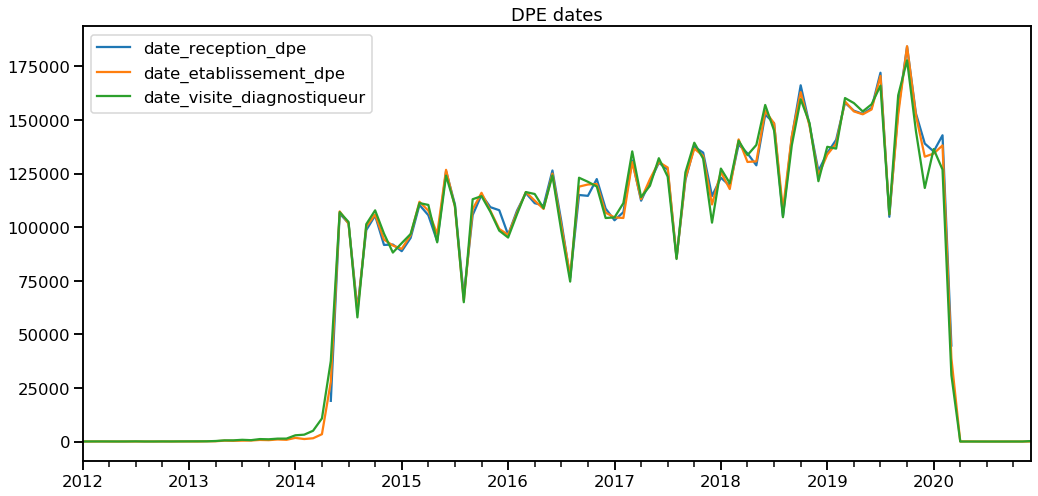

In [8]:
for date,s_date in date_dict.items():
    ax=s_date['2012':'2020'].resample('MS').sum().plot(figsize=(17,8),label = date)
plt.legend()
ax.set_title('DPE dates')
plt.savefig(str(plot_dir/'dates.png'),bbox_inches='tight')


## organismes certificateurs

In [9]:
s_org = pd.Series()
for dpe_table in dept_dict.values():
    s_org = s_org.append(dpe_table.organisme_certificateur)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [10]:
s_org=s_org.str.upper()

In [11]:
s_org.value_counts().head(40) # A UNIFORMISER

ICERT                                  1103908
BUREAU VERITAS CERTIFICATION            636796
I.CERT                                  622171
QUALIXPERT                              446101
AFNOR CERTIFICATION                     406026
GINGER CATED                            372400
BUREAU VERITAS CERTIFICATION FRANCE     274063
DEKRA CERTIFICATION                     258177
SOCOTEC CERTIFICATION                   249519
ABCIDIA CERTIFICATION                   240279
ITGA                                    222302
LCC QUALIXPERT                          179352
BUREAU VERITAS                          171769
B2C                                     159964
ABCIDIA                                 138219
DEKRA                                   115185
PARC EDONIA - BÂTIMENT G                107283
CESI CERTIFICATION                       97849
AFNOR                                    90679
SOCOTEC CERTIFICATION FRANCE             88934
I CERT                                   87396
BUREAU VÉRITA

# indicateurs

In [125]:
cols = ['classe_estimation_ges','classe_consommation_energie','annee_construction','consommation_energie','estimation_ges','dpe_vierge','tr001_modele_dpe_id']
float_cols = ['consommation_energie','estimation_ges','dpe_vierge']

dpe_table_glob= pd.DataFrame()
for dpe_table in dept_dict.values():

    dpe_table_glob = dpe_table_glob.append(dpe_table[cols])
dpe_table_glob[float_cols]=dpe_table_glob[float_cols].astype(float)

## periode construction & annee construction

In [126]:
periode_construction_reglementaire_dict = {
    'avant 1948': (0, 1948),
    'de 1949 à 1974': (1949, 1974),
    'de 1975 à 1981': (1975, 1981),
    'de 1982 à 1987': (1982, 1987),
    'de 1988 à 1999': (1988, 1999),
    'de 2000 à 2005': (2000, 2005),
    "de 2006 à 2012": (2006, 2011),
    "de 2012 à aujourd'hui": (2012, 2100),
}


In [127]:
def intervals_to_category(s, cat_dict):
    """
    transform numerical serie to categorical str enum comparing numerical values with intervals defining the categories.
    Parameters
    ----------
    s : pd.Series
    cat_dict :dict
    a dictionary that have as keys enum categories and as values a tuple of an interval of numerical values.

    Returns
    -------

    """
    s_cat = s.copy()
    for k, v in cat_dict.items():
        s_cat[s.between(*v)] = k
    return s_cat


In [128]:

is_valid = dpe_table_glob.annee_construction.fillna(0).astype(int).between(1000,pd.datetime.now().year)

dpe_table_glob.annee_construction[~is_valid]=np.nan

dpe_table_glob['periode_construction_reglementaire']=intervals_to_category(dpe_table_glob.annee_construction.fillna(0).astype(int),periode_construction_reglementaire_dict)

dpe_table_glob['periode_construction_reglementaire']=dpe_table_glob['periode_construction_reglementaire'].fillna('NA')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [147]:
dpe_table_glob.periode_construction_reglementaire=pd.Categorical(dpe_table_glob.periode_construction_reglementaire,periode_construction_reglementaire_dict.keys(),ordered=True)

## indicateur dpe non valide

In [191]:

dpe_table_glob.classe_consommation_energie=dpe_table_glob.classe_consommation_energie.replace({'H':'N',
                                                   'I':'N',
                                                   'J':'N',
                                                   '-':'N'})
classe_dpe_valides = ['A', 'B', 'C', 'D', 'E', 'F', 'G']




In [130]:
null_ener = ~dpe_table_glob.classe_consommation_energie.isin(classe_dpe_valides)
null_ges=  ~dpe_table_glob.classe_estimation_ges.isin(classe_dpe_valides)

class_null = null_ges|null_ener


In [131]:
is_vierge = dpe_table_glob.dpe_vierge.astype(float)==1

In [132]:
# les DPE vierges biaisent la statistique vers le A car non rempli par défaut à A. 
dpe_table_glob.loc[is_vierge&(~class_null)].classe_consommation_energie.value_counts()

A    89743
D     3860
C     2637
E     2449
B     2157
F     1051
G      696
Name: classe_consommation_energie, dtype: int64

In [238]:
# les DPE vierges biaisent la statistique vers le A car non rempli par défaut à A. 
dpe_table_glob.loc[is_vierge&(~class_null)].classe_consommation_energie.value_counts()

A    89743
D     3860
C     2637
E     2449
B     2157
F     1051
G      696
Name: classe_consommation_energie, dtype: int64

In [133]:
dpe_table_glob['indic_valide']='valide'
dpe_table_glob.loc[class_null,'indic_valide']='classe invalide'

dpe_table_glob.loc[is_vierge,'indic_valide']='vierge'
dpe_table_glob.indic_valide=dpe_table_glob.indic_valide.astype('category')

In [ ]:
dpe_table_glob

## indicateurs incoherences classe/consommation

In [134]:
intervalle_classe_energie = {'A': (0, 51),
                         'B': (51, 91),
                         'C': (91, 151),
                         'D': (151, 231),
                         'E': (231, 331),
                         'F': (331, 451),
                         'G': (451, 1000), }
intervalle_classe_ges = {'A': (0, 6),
                         'B': (6, 11),
                         'C': (11, 21),
                         'D': (21, 36),
                         'E':(36, 56),
                         'F': (56, 80),
                         'G': (80, 500), }
eps = 1e-7
for k,v in intervalle_classe_energie.items():
    intervalle_classe_energie[k]=(v[0],v[1]-eps)
eps = 1e-7
for k,v in intervalle_classe_ges.items():
    intervalle_classe_ges[k]=(v[0],v[1]-eps)

In [135]:
dpe_table_glob['indic_incoherence_conso']='coherent'

for classe in classe_dpe_valides:
    bool_sel=dpe_table_glob.classe_consommation_energie==classe
    sel = dpe_table_glob.loc[bool_sel]
    is_coherent=sel['consommation_energie'].between(*intervalle_classe_energie[classe])
    sel.loc[~is_coherent,'indic_incoherence_conso']='consommation hors limite de classe'
    dpe_table_glob.loc[bool_sel,'indic_incoherence_conso']=sel['indic_incoherence_conso']
    
dpe_table_glob.indic_incoherence_conso=dpe_table_glob.indic_incoherence_conso.astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [136]:
dpe_table_glob.indic_incoherence_conso.value_counts()

coherent                              8294118
consommation hors limite de classe     110531
Name: indic_incoherence_conso, dtype: int64

In [137]:
dpe_table_glob['indic_incoherence_ges']='coherent'

for classe in classe_dpe_valides:
    bool_sel=dpe_table_glob.classe_estimation_ges==classe
    sel = dpe_table_glob.loc[bool_sel]
    is_coherent=sel['estimation_ges'].between(*intervalle_classe_ges[classe])
    sel.loc[~is_coherent,'indic_incoherence_ges']='ges hors limite de classe'
    dpe_table_glob.loc[bool_sel,'indic_incoherence_ges']=sel['indic_incoherence_ges']
dpe_table_glob.indic_incoherence_ges=dpe_table_glob.indic_incoherence_ges.astype('category')

In [138]:
dpe_table_glob.indic_incoherence_ges.value_counts()

coherent                     8303380
ges hors limite de classe     101269
Name: indic_incoherence_ges, dtype: int64

## indicateur suspicion rénovation importante ou erreur

In [139]:
periode_construction_anciennes=['avant 1948', 'de 1949 à 1974', 'de 1975 à 1981', 'de 1982 à 1987']
classe_performantes =['A','B']

In [140]:
is_ancien=dpe_table_glob.periode_construction_reglementaire.isin(periode_construction_anciennes)
is_performant=dpe_table_glob.classe_consommation_energie.isin(classe_performantes)

In [141]:
dpe_table_glob['suspicion_reno_erreur']=(is_ancien)&(is_performant)

# quelques resultats


In [ ]:
dpe_color_palette=sns.color_palette('RdYlGn',7)
dpe_color_palette.reverse()
dpe_color_palette.append((0.9,0.9,0.9))

## distributions consommations par périodes

In [148]:
is_valid=dpe_table_glob.indic_valide=='valide'
is_coherent=(dpe_table_glob.indic_incoherence_ges=='coherent')&(dpe_table_glob.indic_incoherence_conso=='coherent')


data_plot = dpe_table_glob.loc[(is_valid)&(is_coherent)].dropna(axis=0,subset=['consommation_energie','periode_construction_reglementaire'],how='any')

In [150]:
bool_=data_plot.consommation_energie.round(2)<1000

In [162]:

data_plot=data_plot.loc[data_plot.consommation_energie<500]

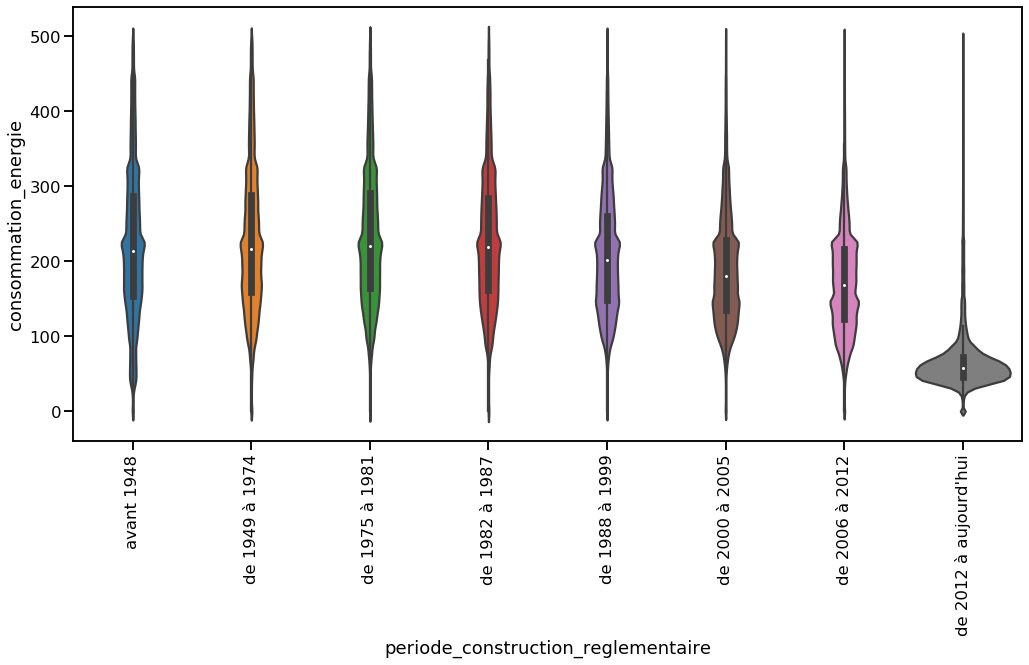

In [165]:
fig=plt.figure(figsize=(17,8))
ax=sns.violinplot(data=data_plot,x='periode_construction_reglementaire',y='consommation_energie')
plt.xticks(rotation=90)
plt.savefig(str(plot_dir/'conso_vs_periodes.png'),bbox_inches='tight')


In [178]:
data_plot = dpe_table_glob


In [179]:
pivot=data_plot.pivot_table(index='periode_construction_reglementaire',columns='classe_consommation_energie',values='consommation_energie',aggfunc='count')

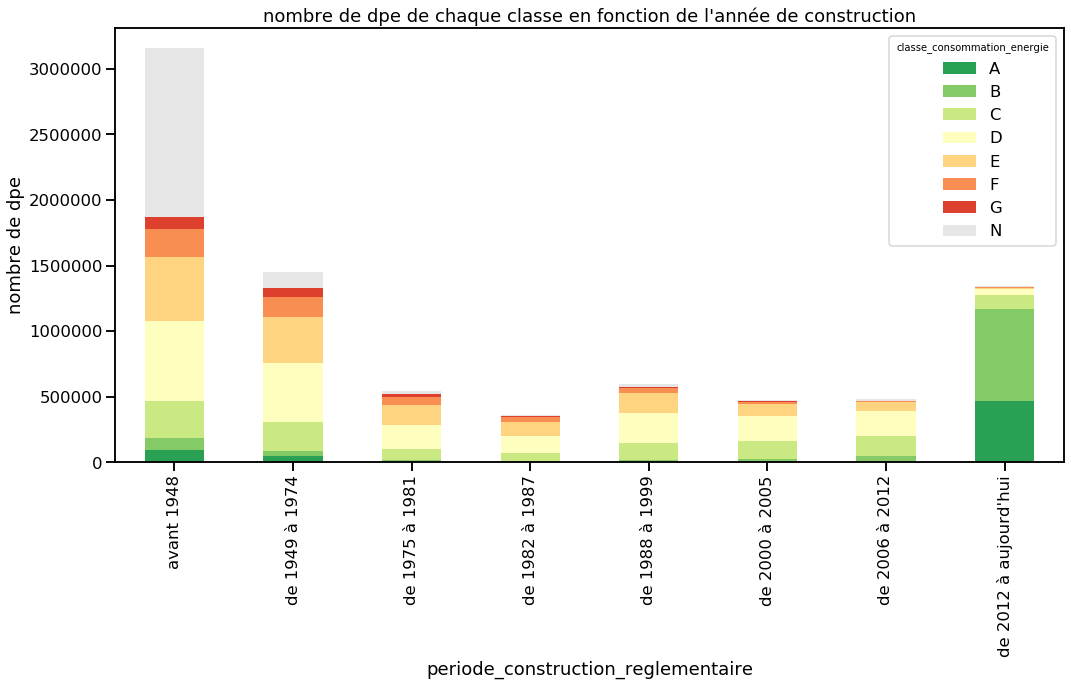

In [228]:
ax=pivot.plot.bar(stacked=True,figsize=(17,8),color=color_palette)
ax.set_ylabel('nombre de dpe')
ax.set_title("nombre de dpe de chaque classe en fonction de l'année de construction")
plt.savefig(str(plot_dir/'etiquettes_vs_periodes.png'),bbox_inches='tight')


## consommation vs etiquette

In [209]:
is_valid=dpe_table_glob.indic_valide=='valide'
is_coherent=(dpe_table_glob.indic_incoherence_ges=='coherent')&(dpe_table_glob.indic_incoherence_conso=='coherent')


data_plot = dpe_table_glob.loc[(is_valid)&(is_coherent)].dropna(axis=0,subset=['consommation_energie','periode_construction_reglementaire'],how='any')

In [1]:
2*3.14*1

6.28

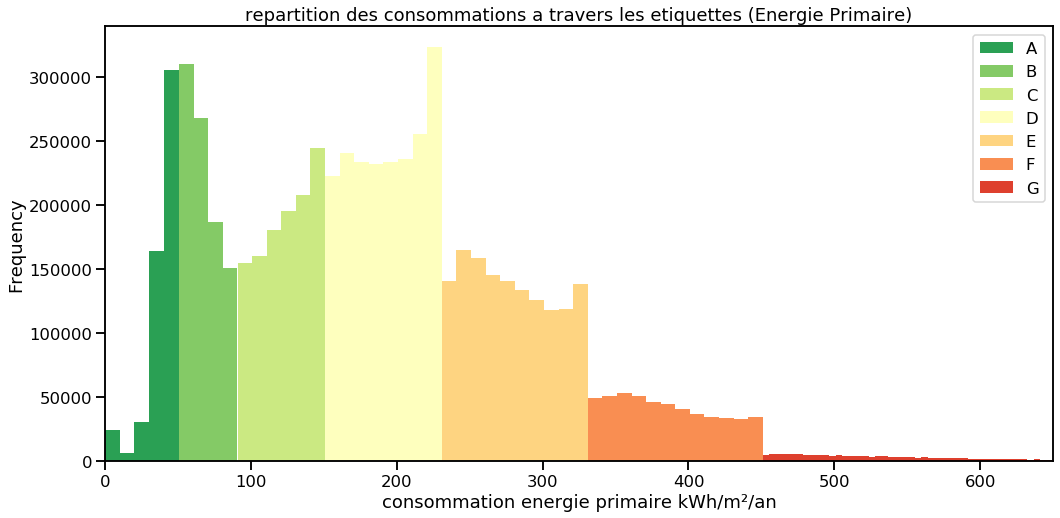

In [235]:
ax = None
for i,classe in enumerate(classe_dpe_valides):
    sel=data_plot.loc[data_plot.classe_consommation_energie==classe]
    
    inter=intervalle_classe_energie[classe]
    nbins = int(np.round((inter[1]-inter[0])/10))
    if ax is None:
        ax=sel.consommation_energie.plot.hist(color=dpe_color_palette[i],figsize=(17,8),bins=nbins)
        ax.set_title('repartition des consommations a travers les etiquettes (Energie Primaire)')
        ax.set_xlabel('consommation energie primaire kWh/m²/an')
        ax.set_xlim(0,650)
    else:
        sel.consommation_energie.plot.hist(color=dpe_color_palette[i],ax=ax,bins=nbins)
plt.legend(classe_dpe_valides)        
plt.savefig(str(plot_dir/'etiquettes_vs_conso.png'),bbox_inches='tight')
